# Simulate Data for Paper

We'd like to simulate some data for the paper, based on the `simulator` in Stingray, so let's do that!

In [1]:
%matplotlib notebook
from stingray import Lightcurve, sampledata

import numpy as np
from scipy import signal
from matplotlib import pyplot as plt
try: 
    import seaborn as sns
    sns.set_style("whitegrid")
    sns.set_context("talk")
    sns.set_palette("colorblind")
except ImportError:
    print("Seaborn not installed. Oh well.")


data_colour = "black"
model_colour = "red"

/Users/danielahuppenkothen/work/sw/miniconda3/lib/python3.6/site-packages/stingray-0.1rc1-py3.6.egg/stingray/utils.py:21: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")


## Simulate a Simple Power spectrum

We are going to simulate a power spectrum with a simple power law and a broad QPO at higher frequencies.

In [2]:
from astropy.modeling import models

In [3]:
m = models.PowerLaw1D() + models.Lorentz1D()

Let's set the parameters:

In [4]:
m.x_0_0.fixed = True

In [302]:
m.amplitude_0 = 0.0001
m.alpha_0 = 2.0
m.amplitude_1 = 250.0
m.x_0_1 = 0.020
m.fwhm_1 = 0.005


In [303]:
true_parameters = [m.amplitude_0.value, m.alpha_0.value, m.amplitude_1.value, m.x_0_1.value, m.fwhm_1.value]

In [304]:
m.parameters

array([1.0e-04, 1.0e+00, 2.0e+00, 2.5e+02, 2.0e-02, 5.0e-03])

In [305]:
tseg = 256*60

In [306]:
freq = np.linspace(1.0/tseg, 10.0, 10*tseg)

In [307]:
spec = m(freq)

<IPython.core.display.Javascript object>


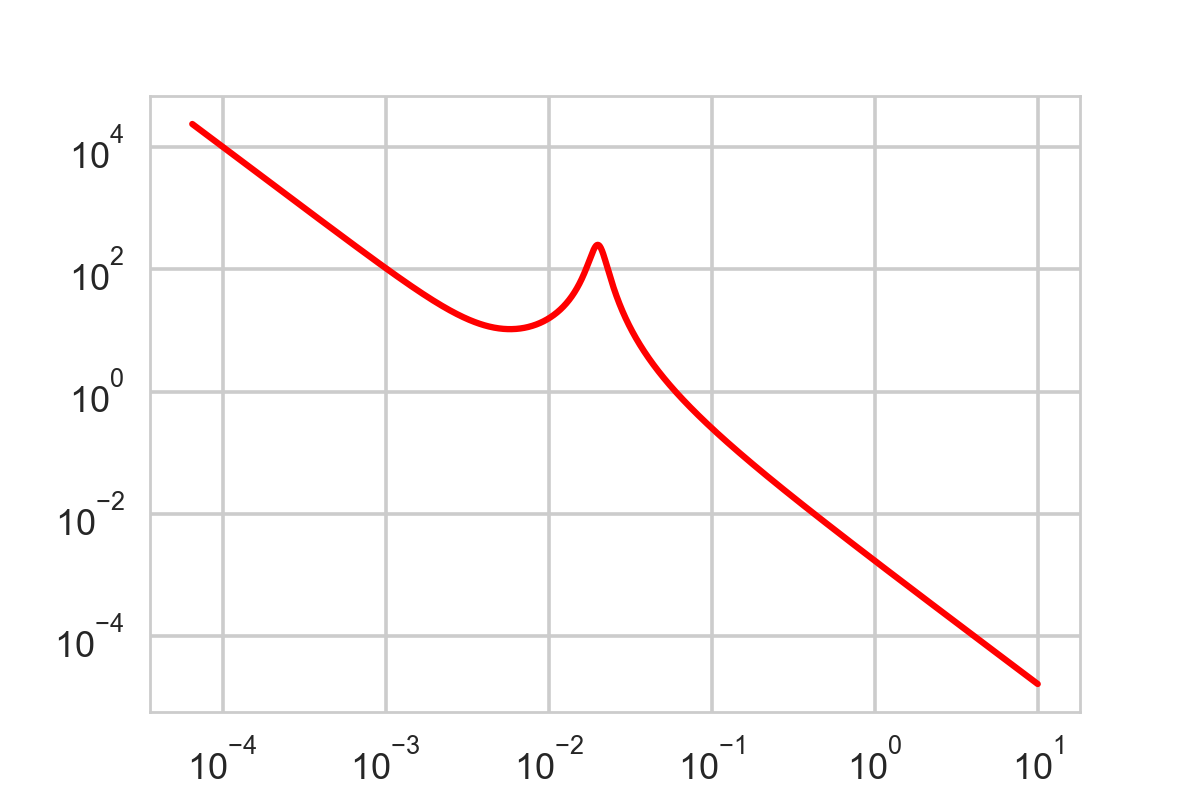

In [308]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.loglog(freq, spec, color=model_colour)

Let's simulate a light curve from this spectrum:

In [309]:
from stingray.simulator import simulator

In [310]:
sim = simulator.Simulator(N=20*tseg, mean=40.0, dt=0.5/10.0, rms=0.2, random_state=42)

In [311]:
20/(0.5/10)

400.0

In [312]:
lc = sim.simulate(spec)

/Users/danielahuppenkothen/work/sw/miniconda3/lib/python3.6/site-packages/stingray-0.1rc1-py3.6.egg/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


In [313]:
lc.dt

0.05

In [314]:
lc.tseg

15360.0

In [315]:
lc.n

307200

In [316]:
counts = np.random.poisson(lc.counts)

In [317]:
counts

array([45, 43, 48, ..., 53, 35, 42])

In [318]:
lc = Lightcurve(lc.time, counts=counts)

<IPython.core.display.Javascript object>


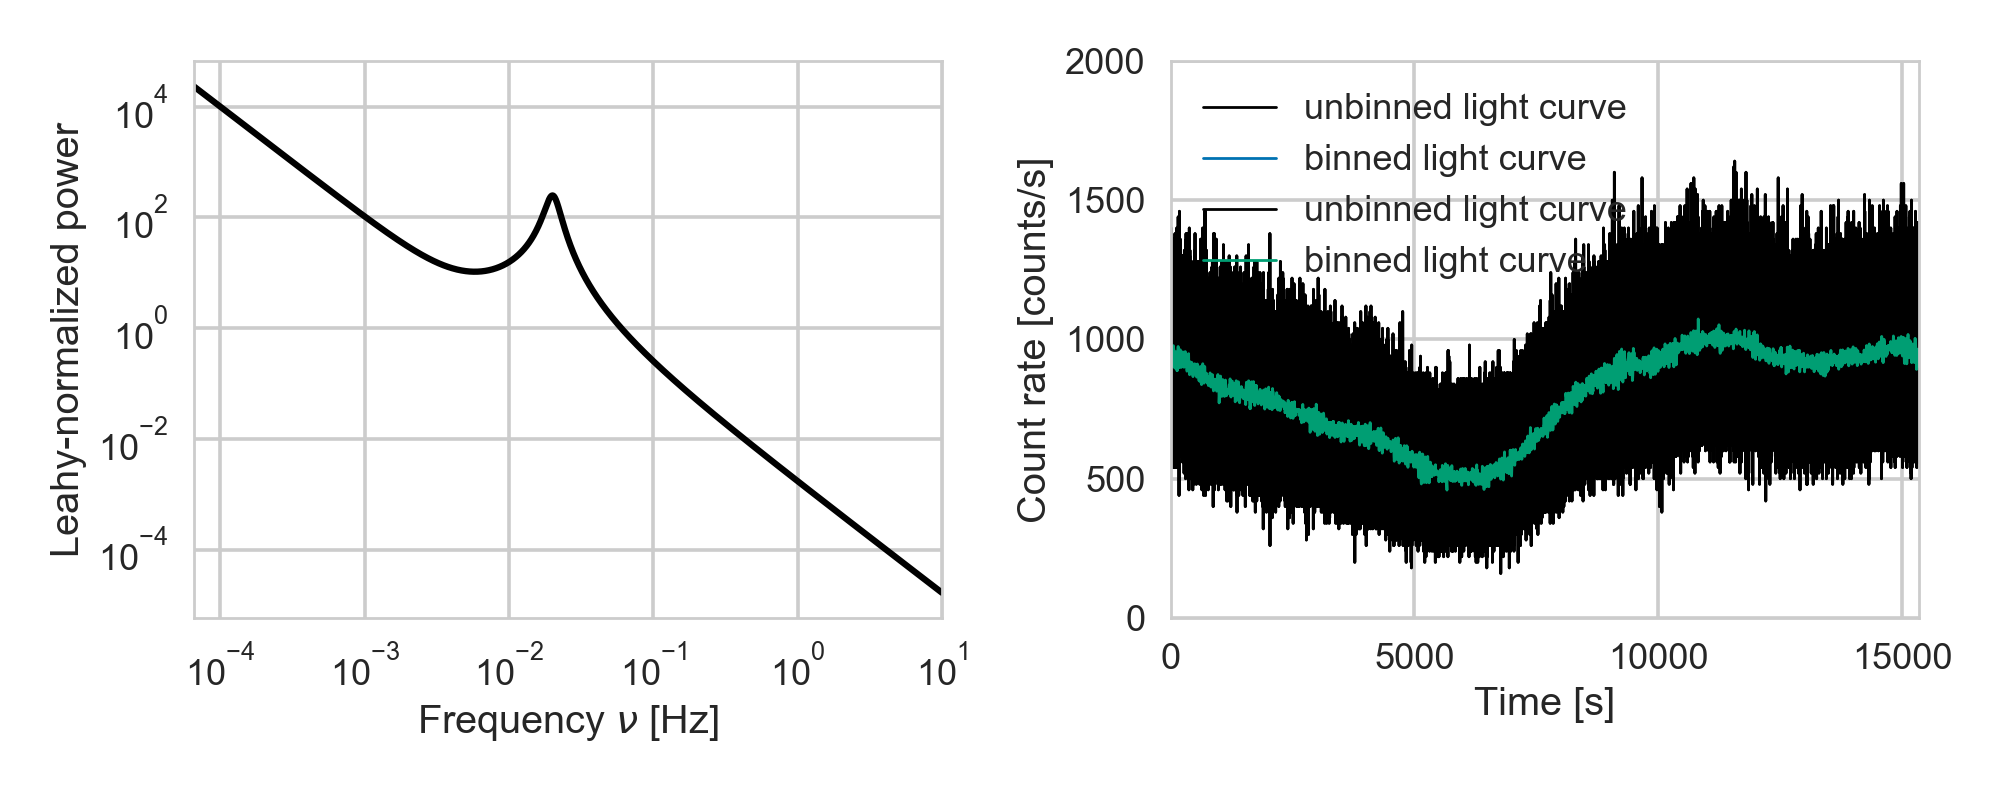

In [319]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.loglog(freq, spec, color=data_colour)
ax1.set_xlabel(r"Frequency $\nu$ [Hz]")
ax1.set_ylabel("Leahy-normalized power")
ax1.set_xlim(freq[0], freq[-1])


ax2.plot(lc.time, lc.countrate, color=data_colour, 
         linewidth=1, label="unbinned light curve")
lcbin = lc.rebin(5.0)
ax2.plot(lcbin.time, lcbin.countrate, lw=1,
             label="binned light curve")
ax2.set_xlim(lcbin.time[0], lcbin.time[-2])
ax2.set_ylim(0, 2000)
ax2.legend()
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Count rate [counts/s]")

plt.tight_layout()
plt.savefig("../figures/sim_lc.pdf", format="pdf")

We can also include GTIs:

In [270]:
gtis = [(0, 2000), (3000, lc.time[-1])]

In [320]:
lc.gti = gtis

In [321]:
lcs = lc.split_by_gti()

<IPython.core.display.Javascript object>


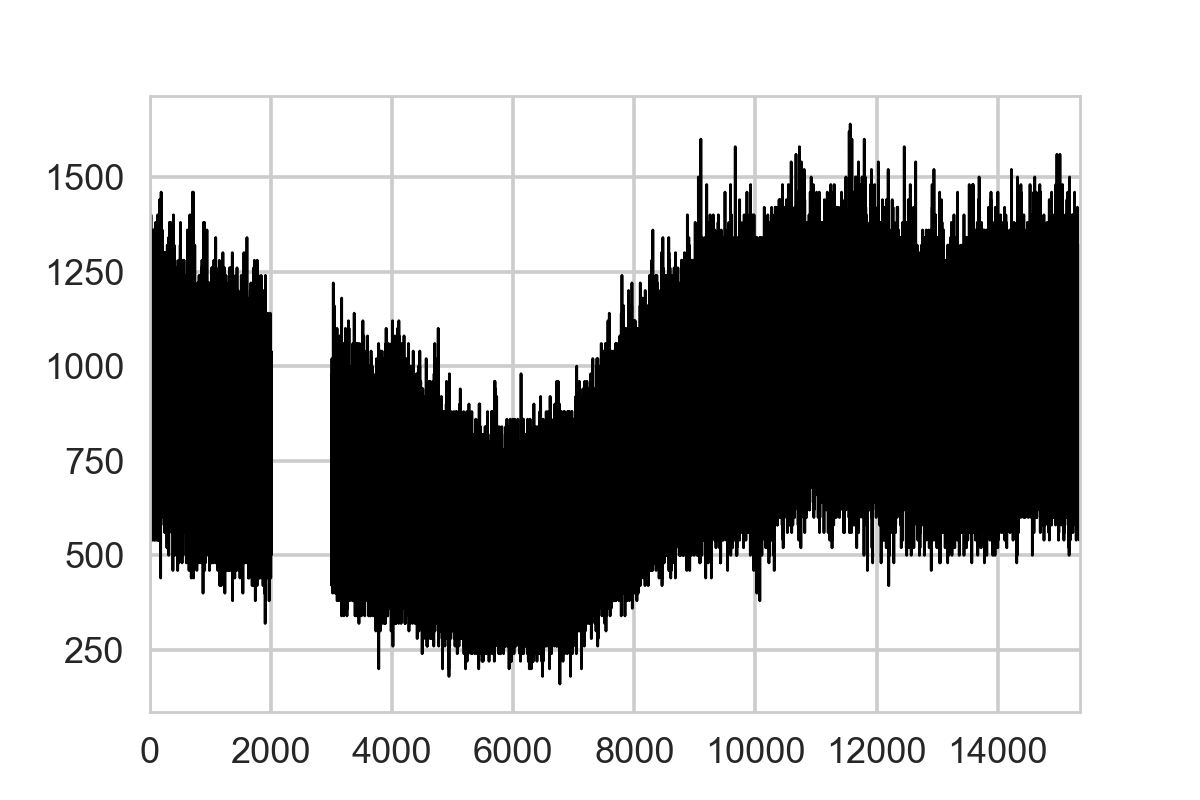

(0.05, 15359.900000000001)

In [322]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for l in lcs:
    ax.plot(l.time, l.countrate, color=data_colour, linewidth=1)

ax.set_xlim(lcs[0].time[0], lcs[-1].time[-1])

Let's make a power spectrum out of the light curve (without GTIs, because I can't make a single power spectrum out of an observation that has non-contiguous GTIs):

In [274]:
from stingray import Powerspectrum

In [323]:
lc.gti = np.array([[lc.time[0], lc.time[-1]]])

In [324]:
ps = Powerspectrum(lc, norm="leahy", gti=None)

<IPython.core.display.Javascript object>


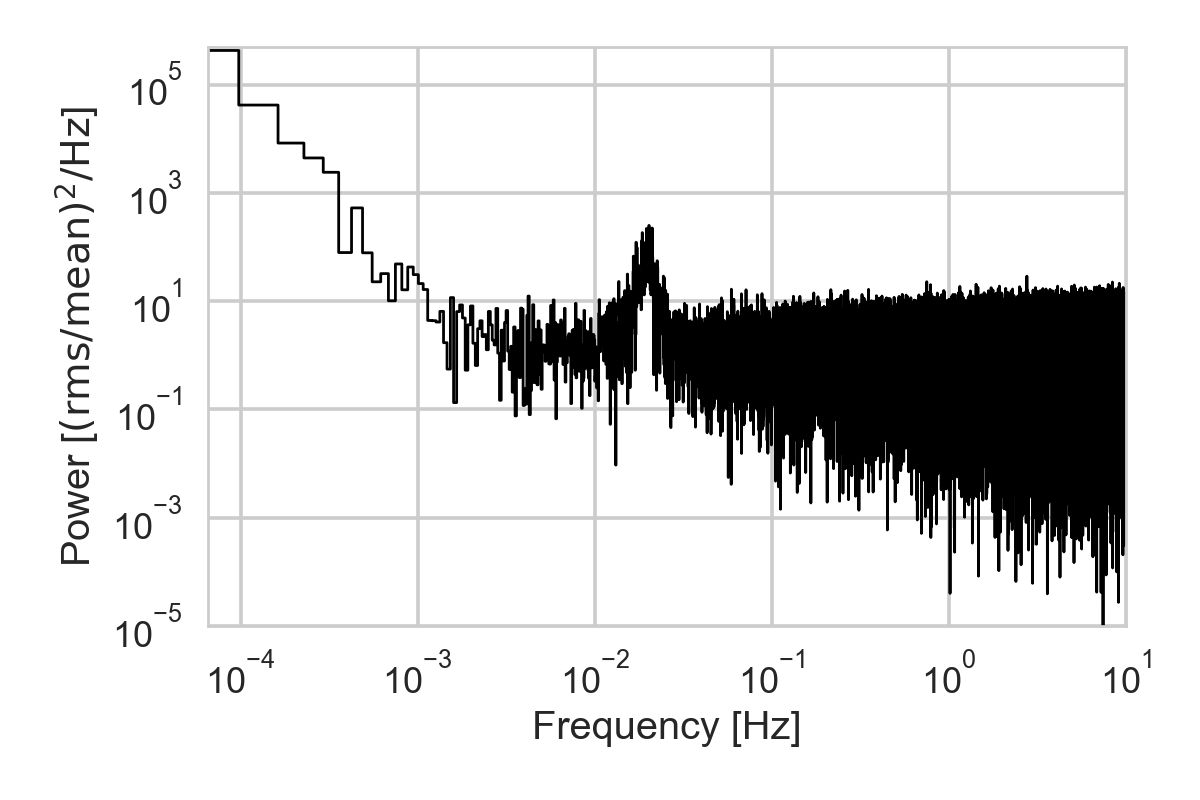

In [325]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.loglog(ps.freq, ps.power, linestyle="steps-mid", lw=1, color=data_colour)
ax.set_xlim(ps.freq[0], ps.freq[-1])
ax.set_ylim(1e-5, 5e5)
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"Power [$(\mathrm{rms}/\mathrm{mean})^2/\mathrm{Hz}$]")

plt.tight_layout()

Let's rebin this so we can see the QPO. We're going to try both geometric rebinning and logarithmic rebinning:

In [326]:
ps_rebin = ps.rebin(df=0.001)
ps_log_rebin = ps.rebin_log()

<IPython.core.display.Javascript object>


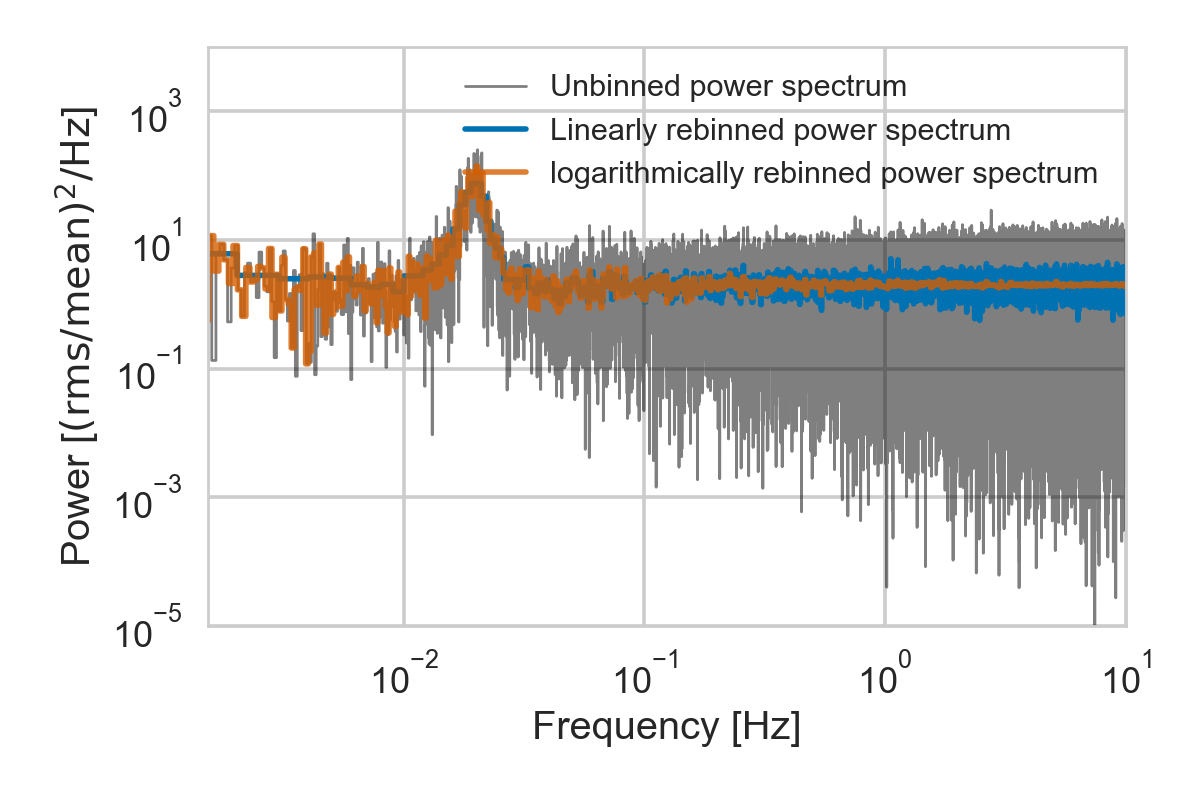

In [327]:
ps_rebin = ps.rebin(df=0.001)
ps_log_rebin = ps.rebin_log()
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.loglog(ps.freq, ps.power, linestyle="steps-mid", color=data_colour, 
         linewidth=1, alpha=0.5, label="Unbinned power spectrum")
ax.loglog(ps_rebin.freq, ps_rebin.power, linestyle="steps-mid", color=sns.color_palette()[0],
         linewidth=2, alpha=1.0, label="Linearly rebinned power spectrum")
ax.loglog(ps_log_rebin.freq, ps_log_rebin.power, linestyle="steps-mid", color=sns.color_palette()[2],
         linewidth=2, alpha=0.8, label="logarithmically rebinned power spectrum")

ax.set_xlim(ps_rebin.freq[1], ps_rebin.freq[-1])
ax.set_ylim(1e-5, 1e4)
ax.legend(loc=1, prop={"size":11})
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"Power [$(\mathrm{rms}/\mathrm{mean})^2/\mathrm{Hz}$]")
plt.tight_layout()


Let's make an averaged powerspectrum so that the QPO is visible:

In [37]:
from stingray import AveragedPowerspectrum

In [328]:
aps = AveragedPowerspectrum(lc, segment_size=256.0)

We can also rebin this version for a much clearer view:

In [329]:
aps_binned = aps.rebin_log()

<IPython.core.display.Javascript object>


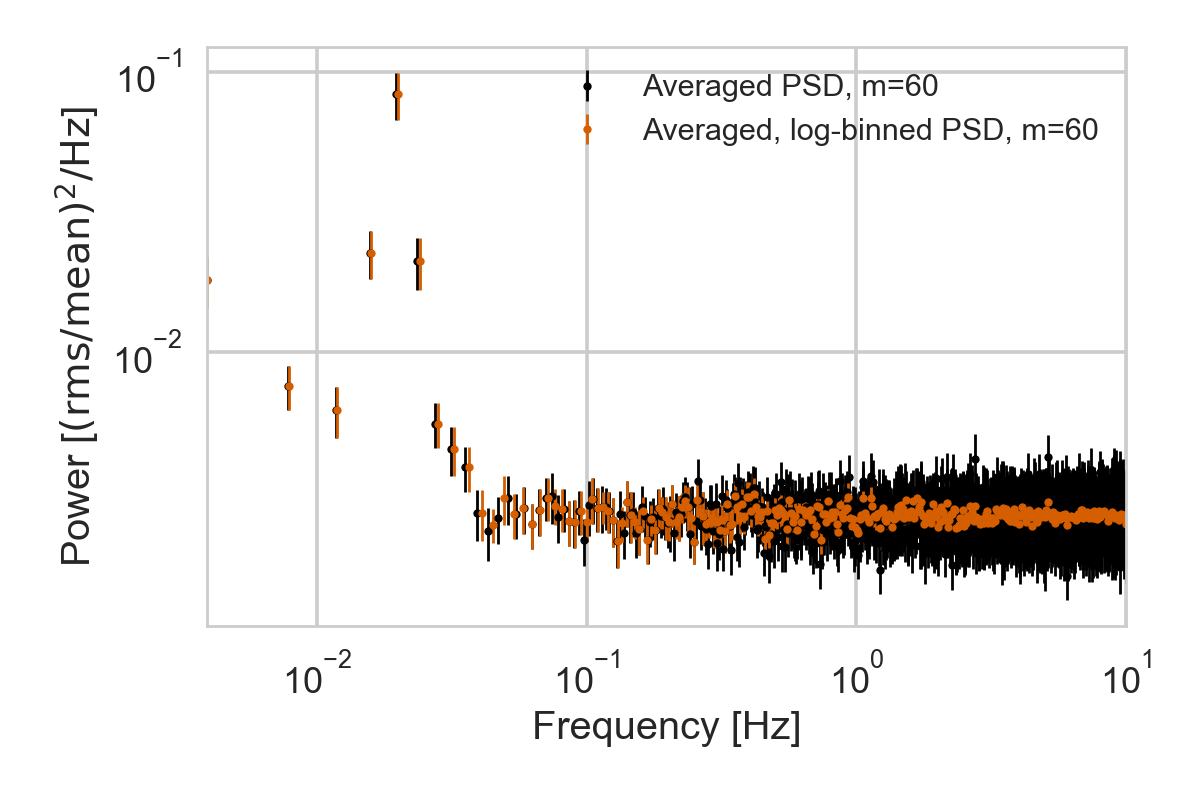

In [330]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.errorbar(aps.freq, aps.power, yerr=aps.power_err, fmt="o", markersize=3, 
            color=data_colour, lw=1, label="Averaged PSD, m=60")

ax.errorbar(aps_binned.freq, aps_binned.power, yerr=aps_binned.power_err, fmt="o", markersize=3, 
            color=sns.color_palette()[2], lw=1, label="Averaged, log-binned PSD, m=60")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(aps.freq[0], aps.freq[-1])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"Power [$(\mathrm{rms}/\mathrm{mean})^2/\mathrm{Hz}$]")
ax.legend(loc=1, prop={"size":11})
plt.tight_layout()

### Altair version:

Awesome! The QPO pops out much more clearly!

### Modeling the power spectrum

We're going to write the modeling section later, but I might as well look at the modeling right now.

So let's take our model and fit it to the averaged power spectrum:

In [284]:
from stingray.modeling import PSDLogLikelihood, PSDPosterior, PSDParEst

First, we'll have to make a `LogLikelihood` object:

In [285]:
m_new = m + models.Const1D()

In [286]:
m_new.x_0_0.fixed = True

In [287]:
loglike = PSDLogLikelihood(ps.freq, ps.power, m_new, m=ps.m)

Let's print an example:

In [288]:
m_new.parameters

array([ 0.1 ,  1.  ,  1.  , 25.  ,  0.2 ,  0.05,  1.  ])

In [303]:
start_pars = [1.5, 1, 10, 0.2, 0.01, 2.0]

In [304]:
loglike.npar

6

In [305]:
loglike(start_pars)

-277726.5459099892

In [306]:
parest = PSDParEst(ps, fitmethod='L-BFGS-B', max_post=False)

In [307]:
res = parest.fit(loglike, start_pars)

In [308]:
res.p_opt

array([1.63761593e-03, 2.01055870e+00, 1.80572656e+02, 2.00032462e-01,
       1.80845270e-02, 1.98794973e+00])

<IPython.core.display.Javascript object>


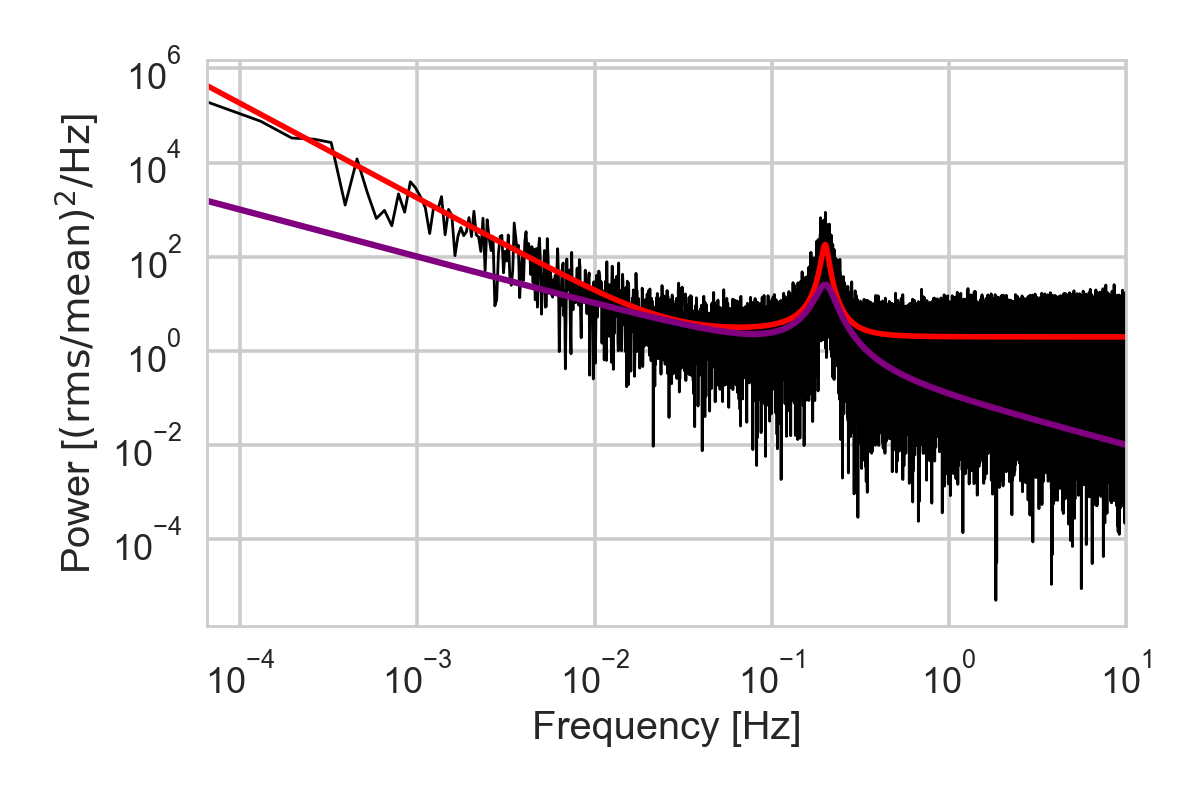

In [309]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.loglog(ps.freq, ps.power, 
            markersize=3, linewidth=1, color=data_colour)
ax.plot(ps.freq, res.mfit, lw=2, color=model_colour)
ax.plot(freq, spec, color="purple")
ax.set_xlim(ps.freq[0], ps.freq[-1])
ax.set_xscale('log')
ax.set_yscale("log")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"Power [$(\mathrm{rms}/\mathrm{mean})^2/\mathrm{Hz}$]")
plt.tight_layout()

Ok, cool. Let's also fit the averaged power spectrum:

In [310]:
len(aps.freq)

2559

In [311]:
np.mean(aps.power[1500:])

0.002584446225236979

In [312]:
aps_parest = PSDParEst(aps, fitmethod='BFGS', max_post=False)

In [313]:
aps_loglike = PSDLogLikelihood(aps.freq, aps.power, m_new, m=aps.m)

In [314]:
m_new.param_names

('amplitude_0',
 'x_0_0',
 'alpha_0',
 'amplitude_1',
 'x_0_1',
 'fwhm_1',
 'amplitude_2')

In [329]:
aps_pars = np.array([0.01, 1, 1, 0.2, 0.04, 0.005])

In [330]:
aps_loglike(aps_pars)

-439664.64064271795

In [331]:
aps_loglike(aps_pars+1.0)

-1919798.439794022

In [332]:

aps_res = aps_parest.fit(aps_loglike, aps_pars)

In [333]:
aps_res.p_opt

array([1.80211161e-06, 2.23671067e+00, 2.41065278e-01, 2.00175577e-01,
       1.93354144e-02, 2.57563953e-03])

In [334]:
test_m = m_new(aps.freq)

<IPython.core.display.Javascript object>


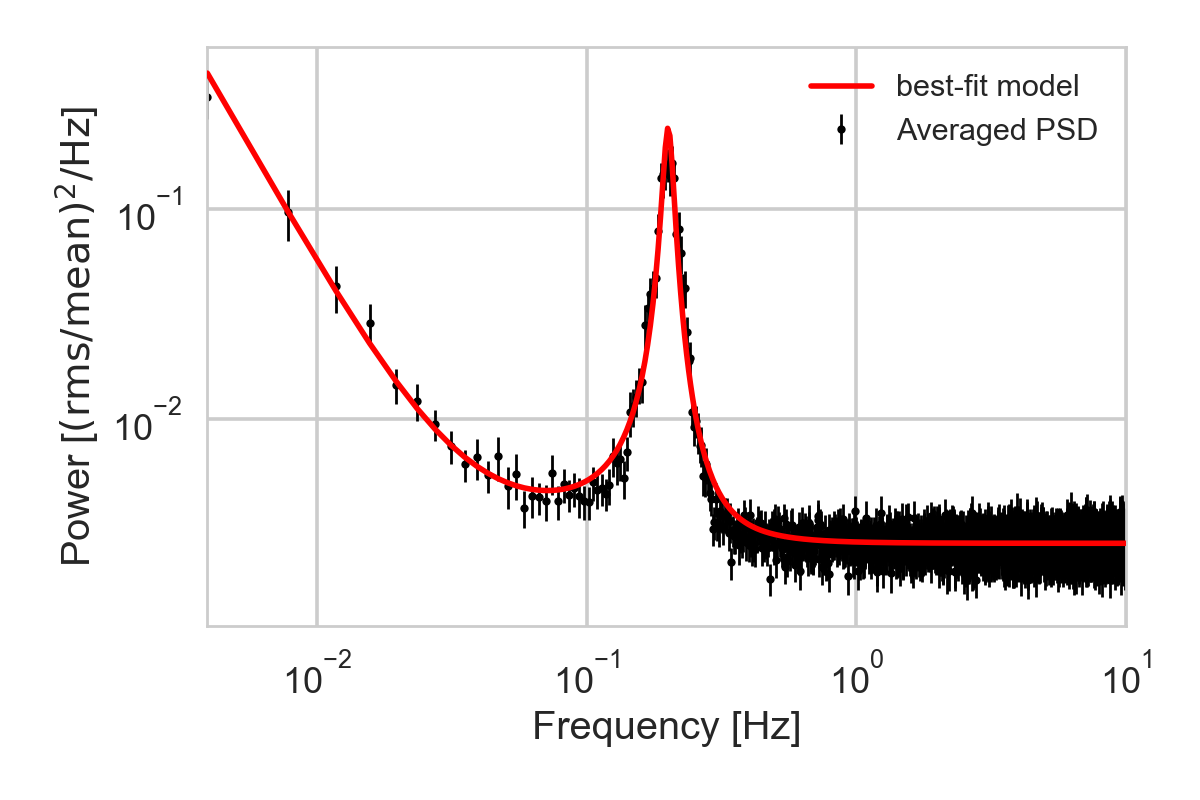

In [335]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.errorbar(aps.freq, aps.power, yerr=aps.power_err, fmt="o",
            markersize=3, linewidth=1, color=data_colour, 
            label="Averaged PSD")
ax.plot(aps.freq, test_m, lw=2, color=model_colour, zorder=10,
        label="best-fit model")
ax.set_xlim(aps.freq[0], aps.freq[-1])
ax.set_xscale('log')
ax.set_yscale("log")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"Power [$(\mathrm{rms}/\mathrm{mean})^2/\mathrm{Hz}$]")
ax.legend(loc=1, prop={"size":11})
plt.tight_layout()

### Sampling

Let's also look at the sampling. For this we are going to need a Posterior object and priors.

In [336]:
m.param_names

('amplitude_0', 'x_0_0', 'alpha_0', 'amplitude_1', 'x_0_1', 'fwhm_1')

In [337]:
import scipy.stats

In [338]:
aps.freq[-1]

9.998046493455877

In [339]:
p_amplitude_0 = lambda amplitude: scipy.stats.uniform(loc=-20, scale=40).pdf(np.log(amplitude))
p_amplitude_1 = lambda amplitude: scipy.stats.uniform(loc=-20, scale=40).pdf(np.log(amplitude))
p_amplitude_2 = lambda amplitude: scipy.stats.uniform(loc=-20, scale=40).pdf(np.log(amplitude))

p_alpha_0 = lambda alpha: scipy.stats.uniform(loc=0, scale=5).pdf(alpha)

p_x_0_1 = lambda x_0_1: scipy.stats.uniform(loc=0.0039, scale=0.0039+9.998).pdf(x_0_1)
p_fwhm_1 = lambda fwhm: scipy.stats.uniform(loc=np.log(0.01), scale=np.log(10.0)-np.log(0.01)).pdf(np.log(fwhm))

In [340]:
prior_dict = {"amplitude_0":p_amplitude_0, "amplitude_1":p_amplitude_1,
              "amplitude_2":p_amplitude_2, "alpha_0": p_alpha_0,
              "x_0_1": p_x_0_1, "fwhm_1":p_fwhm_1}

In [341]:
lpost = PSDPosterior(aps.freq, aps.power, m_new, priors=prior_dict, m=aps.m)

In [342]:
aps_parest = PSDParEst(aps, max_post=True, fitmethod="powell")

In [352]:
aps_pars = [0.01, 1.0, 1, 0.1, 0.05, 0.001]

In [353]:
aps_res = aps_parest.fit(lpost, aps_pars, neg=True)

<IPython.core.display.Javascript object>


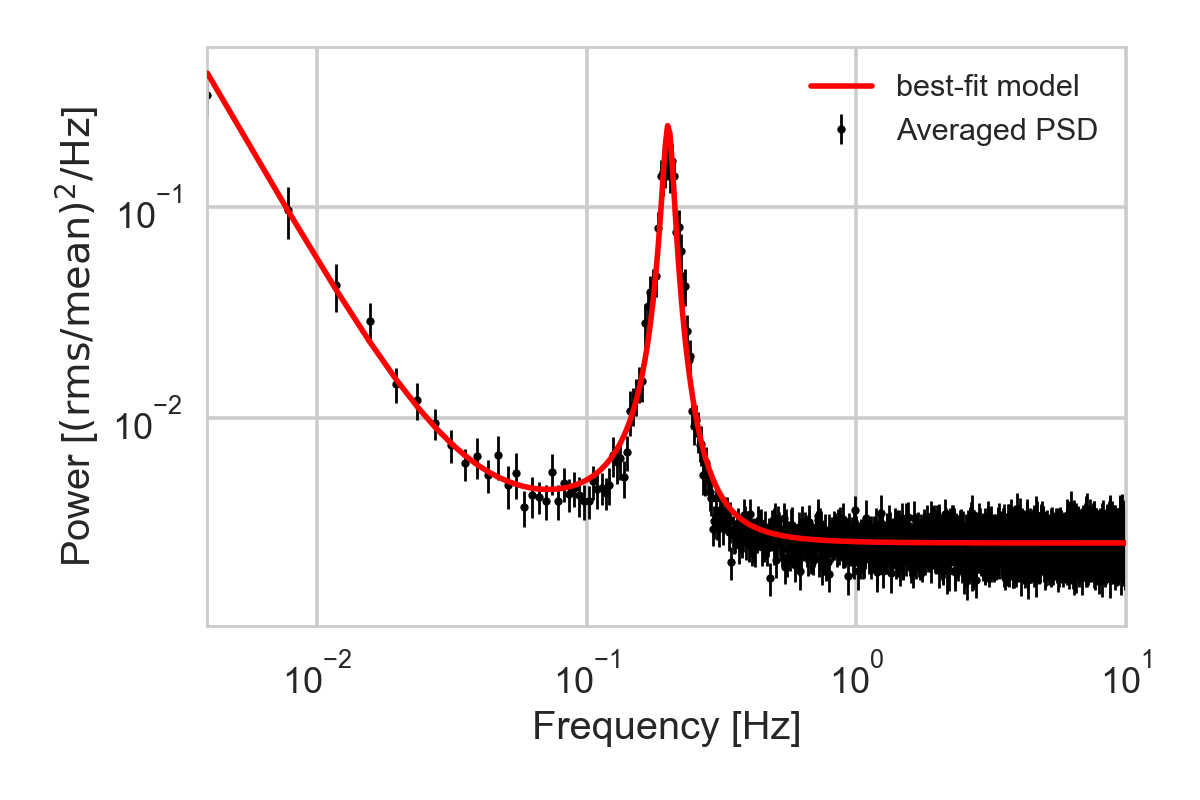

In [354]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.errorbar(aps.freq, aps.power, yerr=aps.power_err, fmt="o",
            markersize=3, linewidth=1, color=data_colour, 
            label="Averaged PSD")
ax.plot(aps.freq, aps_res.mfit, lw=2, color=model_colour, zorder=10,
        label="best-fit model")
ax.set_xlim(aps.freq[0], aps.freq[-1])
ax.set_xscale('log')
ax.set_yscale("log")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"Power [$(\mathrm{rms}/\mathrm{mean})^2/\mathrm{Hz}$]")
ax.legend(loc=1, prop={"size":11})
plt.tight_layout()

Okay, finally, I've got a model. Let's do MCMC:

In [355]:
sample = aps_parest.sample(lpost, aps_res.p_opt, cov=aps_res.cov,
                           nwalkers=200, burnin=100, niter=100, threads=1 )

/Users/danielahuppenkothen/work/sw/miniconda3/lib/python3.6/site-packages/stingray-0.1rc1-py3.6.egg/stingray/modeling/parameterestimation.py:623: RuntimeWarning: covariance is not positive-semidefinite.
  i in range(nwalkers)])
-- The acceptance fraction is: 0.519350.5
-- The acceptance fraction is: 0.519350.5
INFO:MCMC summary:-- The acceptance fraction is: 0.519350.5
R_hat for the parameters is: [7.50086681e-19 8.21742888e-05 1.71164416e-04 8.53301494e-08
 3.51971418e-07 2.65571934e-11]
R_hat for the parameters is: [7.50086681e-19 8.21742888e-05 1.71164416e-04 8.53301494e-08
 3.51971418e-07 2.65571934e-11]
INFO:MCMC summary:R_hat for the parameters is: [7.50086681e-19 8.21742888e-05 1.71164416e-04 8.53301494e-08
 3.51971418e-07 2.65571934e-11]
-- Posterior Summary of Parameters: 

-- Posterior Summary of Parameters: 

INFO:MCMC summary:-- Posterior Summary of Parameters: 

parameter 	 mean 		 sd 		 5% 		 95% 

parameter 	 mean 		 sd 		 5% 		 95% 

INFO:MCMC summary:parameter 	 mean 	

In [356]:
import corner

<IPython.core.display.Javascript object>


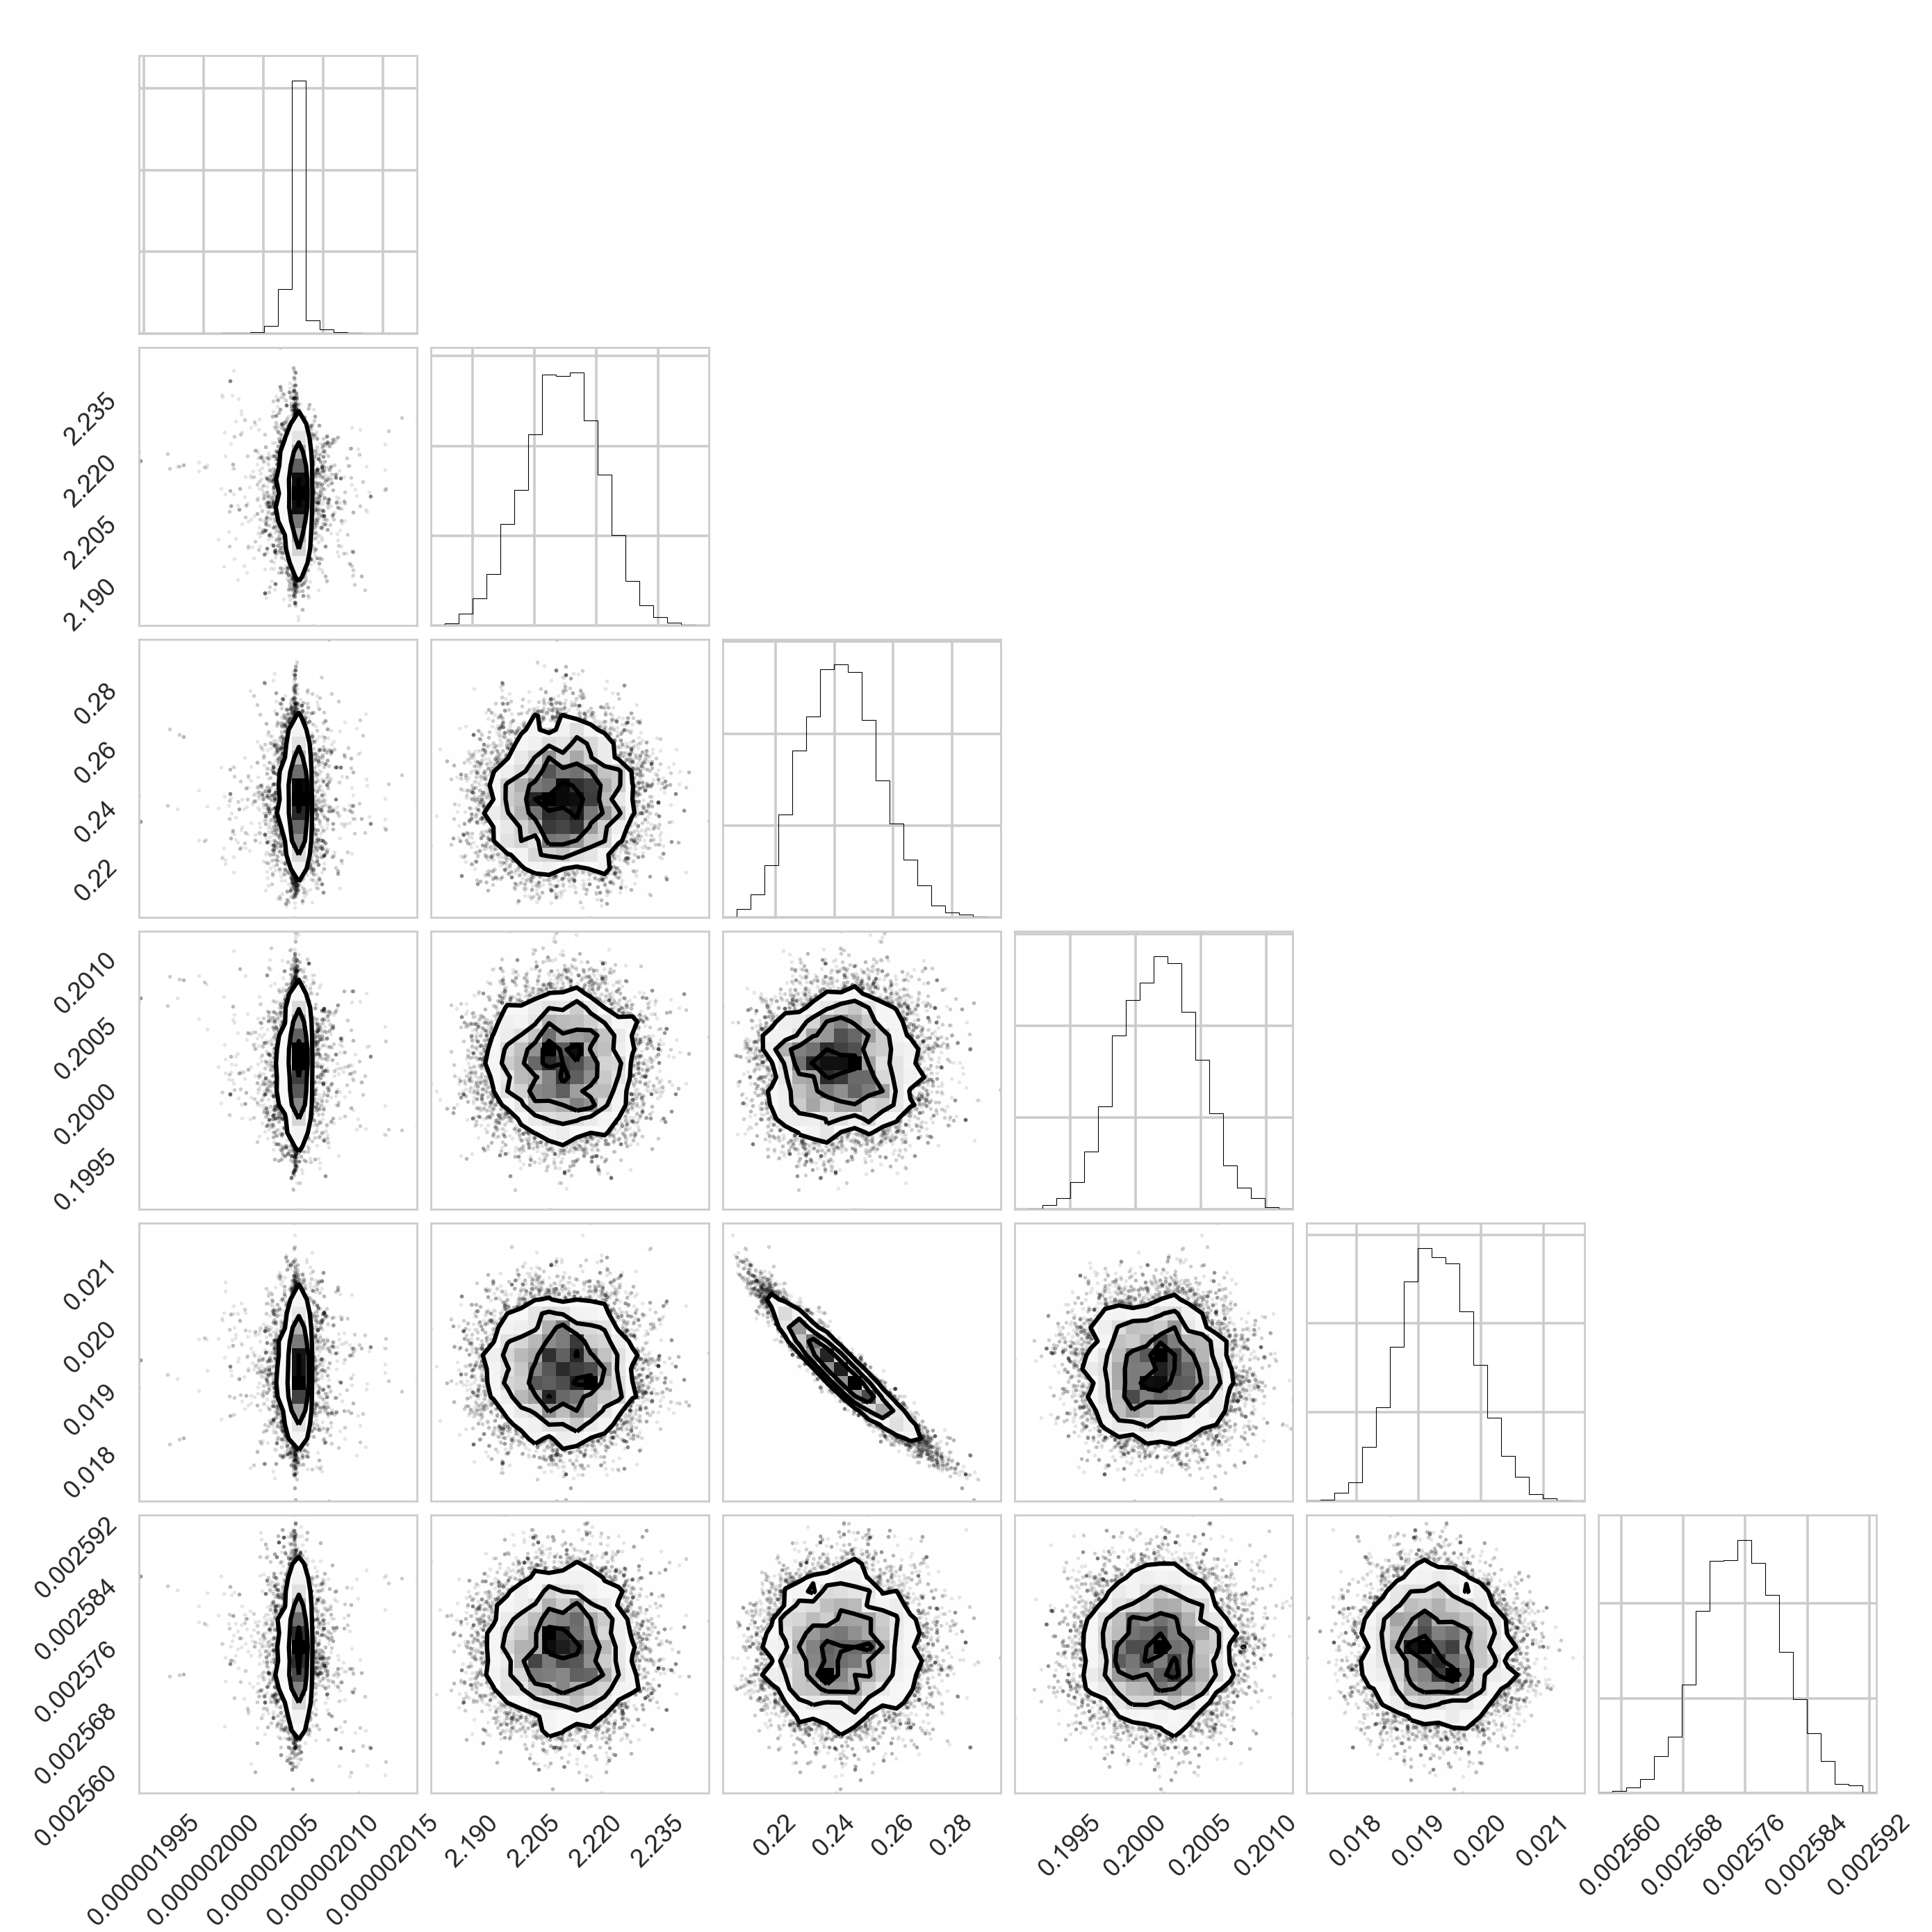

In [357]:
corner.corner(sample.samples);

In [359]:
samples = sample.samples

In [360]:
from astropy.modeling.fitting import _fitter_to_model_params

<IPython.core.display.Javascript object>


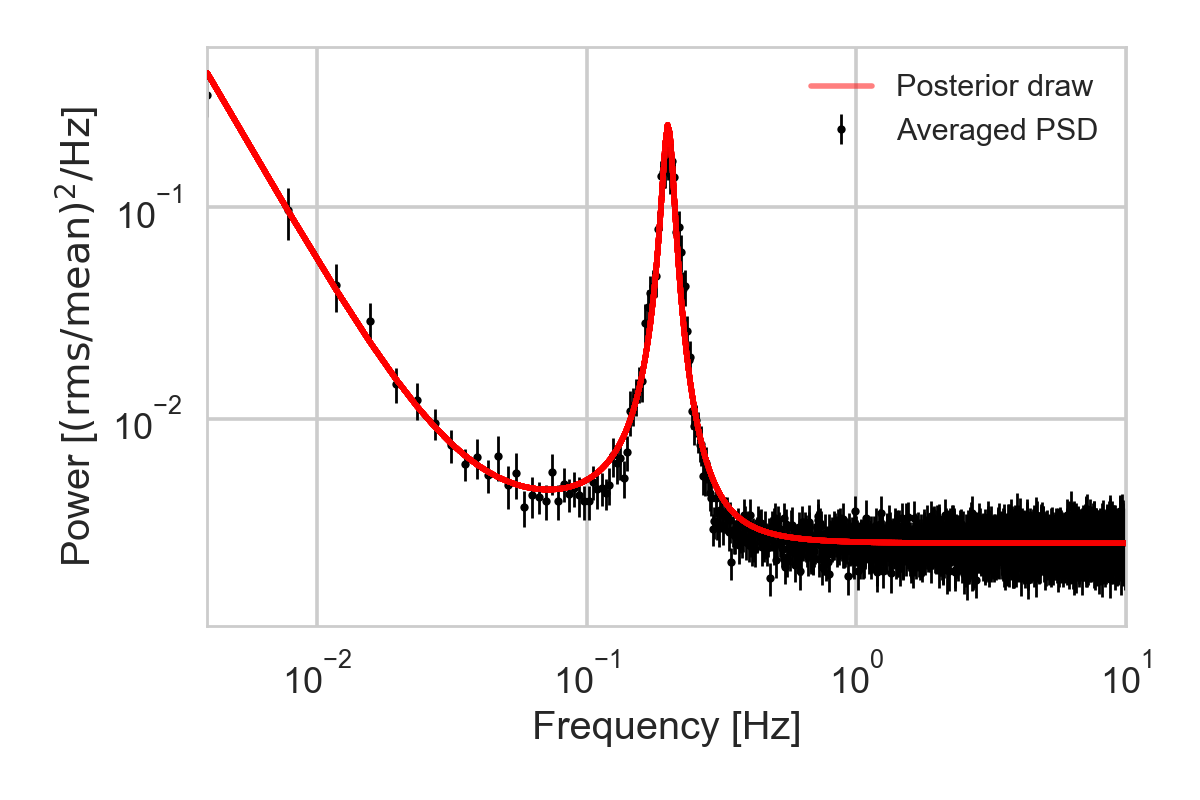

In [361]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.errorbar(aps.freq, aps.power, yerr=aps.power_err, fmt="o",
            markersize=3, linewidth=1, color=data_colour, 
            label="Averaged PSD")
#ax.plot(aps.freq, aps_res.mfit, lw=2, color=model_colour, zorder=10,
#        label="best-fit model")


idx = np.random.choice(np.arange(samples.shape[0], dtype=int), replace=False, size=100)

for i, x in enumerate(idx):
    s = samples[x]
    _fitter_to_model_params(m, s)
    ms = m_new(aps.freq)
    
    if i == 0:
        ax.plot(aps.freq, ms, lw=2, c="red", alpha=0.5, label="Posterior draw", zorder=10)
    else:
        ax.plot(aps.freq, ms, lw=2, c="red", alpha=0.1, zorder=10)

ax.set_xlim(aps.freq[0], aps.freq[-1])
ax.set_xscale('log')
ax.set_yscale("log")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"Power [$(\mathrm{rms}/\mathrm{mean})^2/\mathrm{Hz}$]")
ax.legend(loc=1, prop={"size":11})
plt.tight_layout()

## Time Lags

Let's use the simulator to simulate a light curve with time lags. Impulse response function with width=1 corresponds to a delta function response:

In [138]:
delay=50.0
s_ir = sim.simple_ir(start=delay, width=lc.dt, intensity=1.0)

In [139]:
lc_new = sim.simulate(lc.counts, s_ir)

/Users/danielahuppenkothen/work/sw/miniconda3/lib/python3.6/site-packages/stingray-0.1rc1-py3.6.egg/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


<IPython.core.display.Javascript object>


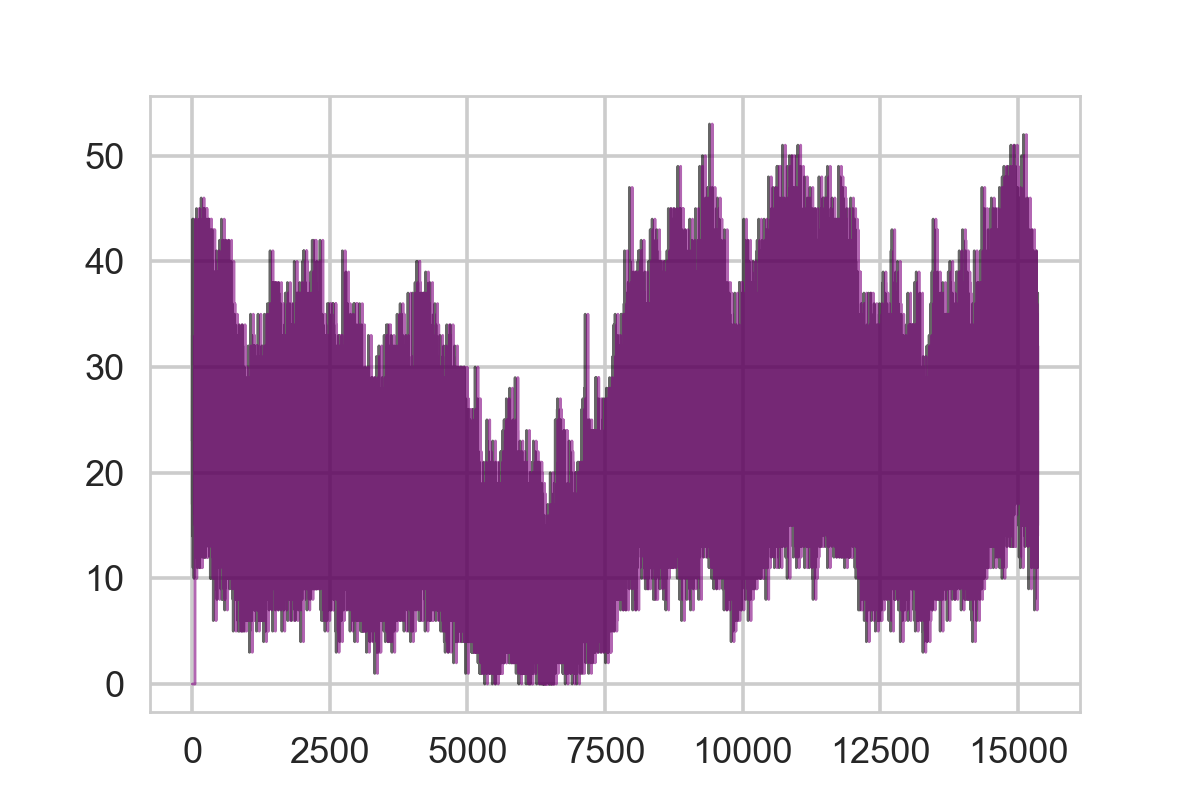

In [140]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(lc.time, lc.counts, lw=1, color="black", linestyle="steps-mid", alpha=0.6)
ax.plot(lc_new.time, lc_new.counts, lw=1, color="purple", linestyle="steps-mid", alpha=0.6)

#ax.set_xlim(lc.time[5000], lc.time[5500])

In [102]:
from stingray import Crossspectrum

In [141]:
len(lc.time)

307200

In [142]:
len(lc_new.time)

307200

In [143]:
lc_new.gti = lc.gti

In [149]:
cross = Crossspectrum(lc, lc_new)

/Users/danielahuppenkothen/work/sw/miniconda3/lib/python3.6/site-packages/stingray-0.1rc1-py3.6.egg/stingray/utils.py:89: UserWarning: SIMON says: Your lightcurves have different statistics.The errors in the Crossspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/Users/danielahuppenkothen/work/sw/miniconda3/lib/python3.6/site-packages/stingray-0.1rc1-py3.6.egg/stingray/utils.py:89: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/Users/danielahuppenkothen/work/sw/miniconda3/lib/python3.6/site-packages/stingray-0.1rc1-py3.6.egg/stingray/utils.py:89: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/Users/danielahuppenkothen/work/sw/miniconda3/lib/python3.6/site-packages/stingray-0.1rc1-py3.6.egg/stin

In [150]:
cross.df

6.510459052467788e-05

In [151]:
cross = cross.rebin(0.001)

In [152]:
lag = np.angle(cross.power)/ (2 * np.pi * cross.freq)

<IPython.core.display.Javascript object>


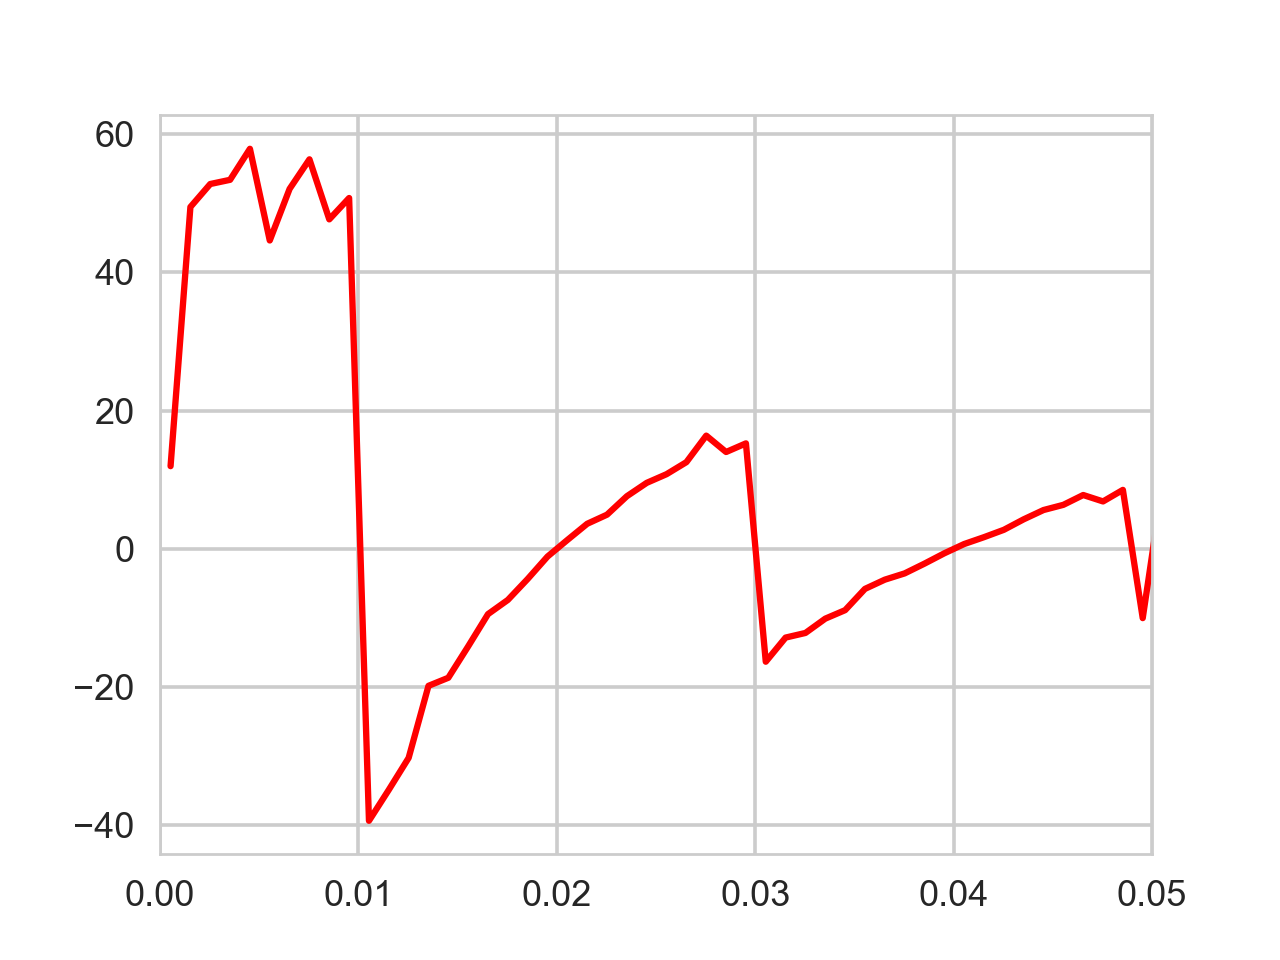

(0, 0.05)

In [155]:
plt.figure()

# Plot lag-frequency spectrum.
plt.plot(cross.freq, lag, 'r')

plt.xlim(0, 0.05)

In [156]:
delays = [10,20, 30, 40, 30, 20 ]

h_all = []

for d in delays:
    h = sim.simple_ir(start=d, width=lc.dt)
    h_all.append(h)

In [ ]:
energies = ["0.5-1.5", "1.5-2.5", "2.5-3.5", "3.5-4.5", "4.5-5.5", "5.5-6.5"]

In [ ]:
sim.simulate_channel('3.5-4.5', var, h1)
sim.simulate_channel('4.5-5.5', var, h2)


Old stuff from previous notebook:

In [ ]:
lc = sampledata.sample_data()

In [ ]:
lc.dt

Let's first plot the light curve:

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(lc.time-lc.time[0], lc.countrate, color=data_colour)
ax.set_xlim(0.0, lc.tseg)
ax.set_xlabel(r"Time in seconds since $t_{\mathrm{start}}$")
ax.set_ylabel("Count rate [counts/s]")
plt.tight_layout()

### Power spectrum

Let's make a Power spectrum:


In [ ]:
from stingray import Powerspectrum

In [ ]:
ps = Powerspectrum(lc, norm="frac")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.loglog(ps.freq, ps.power, color=data_colour,
          linestyle="steps-mid")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(ps.freq[0], ps.freq[-1])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"Power [$(\mathrm{rms}/\mathrm{mean})^2/\mathrm{Hz}$]")
plt.tight_layout()

### Averaged Powerspectrum

In [ ]:
from stingray import AveragedPowerspectrum

In [ ]:
lc.tseg

The light curve is long enough that I can make about 20 segments of 128s each:

In [ ]:
aps = AveragedPowerspectrum(lc, segment_size=2*128.0)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.errorbar(aps.freq, aps.power, yerr=aps.power_err, 
           linestyle="steps-mid", color=data_colour, fmt="o", 
            markersize=4, linewidth=1)
ax.set_xscale("log")
ax.set_yscale('log')
ax.set_xlim(aps.freq[0], aps.freq[-1])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"Power [$(\mathrm{rms}/\mathrm{mean})^2/\mathrm{Hz}$]")
plt.tight_layout()

### Let's make a cross spectrum

In [ ]:
from stingray import AveragedCrossspectrum

In [ ]:
cps = AveragedCrossspectrum()